<a href="https://colab.research.google.com/github/AndisDraguns/rasp-lab/blob/main/Integer_Factoring_Verification_Transformer_in_RASPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Integer Factoring Verification Transformer With log(n)-depth Multiplication in RASPy

I implement an [RSA factoring](https://en.wikipedia.org/wiki/RSA_Factoring_Challenge) verifier as a Transformer circuit by using RASPy programming language to build a multiplication circuit with depth log(n). This can serve as a toy example for a Transformer that is hard to reverse, and showcase theoretical cases that would be difficult for algorithms such as [Greedy Coordinate Descent](https://arxiv.org/pdf/2307.15043.pdf).

RASP is a programming language that allows implementing handcrafted Transformer circuits. It can be used to to make Transformers perform simple algorithms such as reversing a string in a way that achieves length-generalization. For a great introduction on RASP, see this blog https://srush.github.io/raspy/ from which this notebook is adapted.

Since only a limited set of computations is [easy to effectivelly express as Transformers circuits](https://arxiv.org/pdf/2310.16028.pdf), even straightforward algorithms such as addition can be somewhat nontrivial to build in RASP. The simplest way of writing a multiplication algorithm yields a circuit that has depth O(n), which would make it harder to multiply large numbers. For this reason I parallelise the summation steps to compute multiplication in depth O(log n). The current implementation verifies a 250-digit RSA number factoring using 31 Transformer layers.

# Installing RASPy

In [52]:
# %%
!pip install -qqq git+https://github.com/chalk-diagrams/chalk git+https://github.com/srush/RASPy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [53]:
from raspy import *
from raspy.rasp import Seq, Sel, SOp, Key, Query
from raspy.visualize import draw_all, draw, draw_sel
from chalk import *
from colour import Color
from raspy.visualize import word

import sys
from typing import Iterable

# RASPy Helper Functions

These functions are from the [RASPy implementation](https://github.com/srush/RASPy).

In [54]:
# useful constants:
length = (key(1) == query(1)).value(1)  # [len, len, ..., len]
before = key(indices) < query(indices)  # selects before

def cumsum(seq: SOp = tokens)-> SOp:
    """cumulative sum along the SOp"""
    x = (before | (key(indices) == query(indices))).value(seq)
    return x.name("cumsum")

def shift(i: int = 1, default = "_", seq: SOp = tokens)-> SOp:
    """shifts seq i positions to the right. E.g. [1,2,3]->["_",1,2] for i=1"""
    x = (key(indices) == query(indices-i)).value(seq, default)
    return x.name("shift")

def ralign(default = "-", seq: SOp = tokens)-> SOp:
    """aligns seq to the right. E.g. [1,"_",3,"_"]->["-","-",1,2]"""
    c = (key(seq) == query("_")).value(1)
    x = (key(indices + c) == query(indices)).value(seq, default)
    return x.name("ralign")

def split(v: SOp, get_first_part: bool, sop = tokens, default = "0")-> SOp:
    """returns the first part (before v) or after"""
    split_point = (key(sop) == query(v)).value(indices)
    if get_first_part:
        x = ralign(default, where(indices < split_point, sop, "_"))
        return x
    else:
        x = where(indices > split_point, sop, default)
        return x

def slide(match: SOp, seq = tokens)-> SOp:
    """fills nonmatching regions with the next value on the right"""
    x = cumsum(match)
    y = ((key(x) == query(x + 1)) & (key(match) == query(True))).value(seq)
    seq =  where(match, seq, y)
    return seq.name("slide")

# Password Checker

We will need this for verifying that the result of the multiplication exactly matches the correct number, e.g. the big product of two ***unknown*** primes.

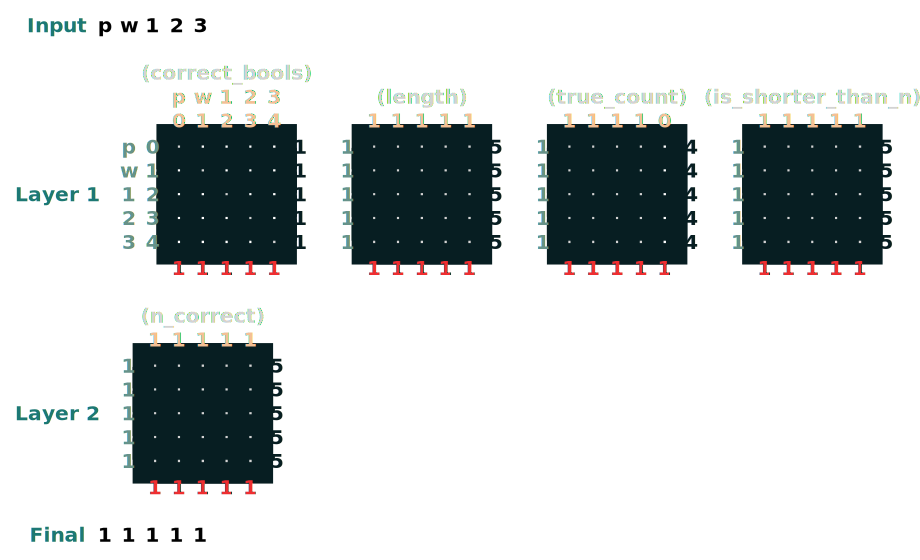

In [55]:
def hardcode_SOp(iterable: Iterable)-> SOp:
    """ e.g. "abc" -> ["a", "b", "c", "_", "_"] if indices length is 5"""
    return indices.map(lambda x: iterable[x] if x < len(iterable) else "_").name("hardcoded_SOp")

def check_if_all_true(bools: SOp) -> rasp.SOp:
    """returns all True if all bools are True; else returns all False"""
    true_count = (key(bools) == query(1)).value(1).name("true_count")
    return true_count == length

def check_if_len_smaller_than_n(n: int) -> SOp:
    """returns all True if indices length < n; else all False"""
    inverted_one_hot_n = hardcode_SOp([True]*(n-1)+[False]).name("inverted_one_hot_n")
    is_shorter_than_n = check_if_all_true(inverted_one_hot_n).name("is_shorter_than_n")
    return is_shorter_than_n

def password_check(hardcoded_password="pw123", input_string: SOp=tokens):
    """
    returns all True if input string matches hardcoded_password
    correct input will still work with appended "_" symbols
    else returns all False
    """
    hardcoded_pw_len = len(hardcoded_password)
    id = (key(indices) == query(indices))
    length = (key(1) == query(1)).value(1).name("length")
    same_val_selector = (key(input_string) == query(hardcode_SOp(hardcoded_password)))
    correct_bools = (same_val_selector & id).value(1).name("correct_bools")
    n_correct = (key(correct_bools) == query(1)).value(1).name("n_correct")
    output = n_correct == length
    not_shorter_than_n = check_if_len_smaller_than_n(hardcoded_pw_len).map(lambda x: not x)
    verified_output = output & not_shorter_than_n
    return verified_output.name("pw_check")

password_check()("pw123")

# Operations in Base b

Useful for adjusting the base to optimise the speed of running the Transformer. Higher base leads to shorter input sequences but increases the vocab size.

In [56]:
class BasedNumber:
    def __init__(self, value: Union[int, list[int]], base: int):
        self.base: int = base
        if isinstance(value, int): # base 10 int
            self.value_base_10: int = value
            self.digits_int: list[int] = base_10_to_base_b(self.value_base_10, base)
        else: # base b int list
            self.digits_int: list[int] = value
            self.value_base_10: int = base_b_to_base_10(self.digits_int, base)
        self.digits: list[str] = [str(x) for x in self.digits_int]
    def __repr__(self):
        return self.string
    def __str__(self):
        return str(list_to_str(self.digits))
    def __eq__(self, other)-> bool:
        if isinstance(other, int):
            return self.value_base_10 == other
        else:
            return self.value_base_10 == other.value_base_10
    def __add__(self, other):
        return BasedNumber(self.value_base_10 + other.value_base_10, self.base)
    def __mul__(self, other):
        return BasedNumber(self.value_base_10 * other.value_base_10, self.base)

def base_10_to_base_b(number: int, base: int)-> list[int]:
    if number == 0:
        return [0]
    digits = []
    while number:
        digits.append(int(number % base))
        number //= base
    return digits[::-1]

def base_b_to_base_10(digits: list[int], base: int)-> int:
    """ e.g. [1,0,1]->5 for base 2 """
    return sum(d * base ** i for i, d in enumerate(digits[::-1]))

def list_to_str(lst: list)-> str:
    """ e.g. [1,2,3]->'123' """
    return "".join([str(x) for x in lst])

In [57]:
def strings_to_ints(strings: SOp)-> SOp:
    return strings.map(lambda x: int(x))

def add_2_numbers(x: SOp, y: SOp, base: int)-> SOp:
    """ e.g. [3, 4], [2, 7] -> [6, 1] """
    elementwise_sum = (x + y).name("elementwise_sum")
    gets_carry = shift(-1, "0", where(elementwise_sum > (base-1), "1", where(elementwise_sum == (base-1), "<", "0")))
    gets_carry = strings_to_ints(slide(gets_carry != "<", gets_carry))
    return (elementwise_sum + gets_carry) % base

def single_digit_multiplication(number: SOp, digit: SOp, base: int)-> SOp:
    """ e.g. 683 * 5: ep 30 40 15; q 3 4 1; r 0 0 5; sq 3 4 1 0; sdp 3 4 1 5 """
    if base == 2:
        return (number * digit).name("single_digit_product")
    elementwise_product = (number * digit).name("elementwise_product")
    quotient = elementwise_product.map(lambda x: x // base).name("quotient")
    remainder = (elementwise_product % base).name("remainder")
    shifted_quotient = shift(-1, seq=quotient, default=0).name("shifted_quotient")
    single_digit_product = add_2_numbers(remainder, shifted_quotient, base=base)
    return single_digit_product.name("single_digit_product")

def add_adjacent_pairs(summands: list[SOp], base: int, n: int)-> SOp:
    """ e.g. [a,b,c,d,e] -> [a+b,c+d,e] """
    n_summands = len(summands)
    n_summands_is_odd = n_summands % 2 != 0
    n_pairs = n_summands // 2
    added = [add_2_numbers(summands[i], summands[i+1], base=base).name(f"sum_{i}") for i in range(0, n_pairs*2, 2)]
    if n_summands_is_odd: # if one leftover summand
        added.append(summands[-1])
    return added

def multiply_n_depth(base: int, n: int, candidate_factors: SOp = tokens):
    """ e.g. ['3', '4', '*', '2', '7'] -> ['0', '0', '9', '1', '8'] """
    x = strings_to_ints(split("*", True, candidate_factors).name("x"))
    y = strings_to_ints(split("*", False, candidate_factors).name("y"))
    product = indices.map(lambda i: 0).name("product")
    for i in range(n):
        y_ith_ls_digit = (key(indices)==query(length-1-i)).value(y).name("y_ith_ls_digit")
        partial = single_digit_multiplication(x, y_ith_ls_digit, base).name("partial")
        shifted_partial = shift(-i, seq=partial, default=0).name("shifted_partial")
        product = add_2_numbers(product, shifted_partial, base=base).name("product")
    return product

def multiply_logn_depth(base: int, n: int, candidate_factors: SOp = tokens)-> SOp:
    """ e.g. ['3', '4', '*', '2', '7'] -> ['0', '0', '9', '1', '8'] """
    x = strings_to_ints(split("*", True, candidate_factors).name("x"))
    y = strings_to_ints(split("*", False, candidate_factors).name("y"))
    y_digit_list = [(key(indices)==query(length-1-i)).value(y).name(f"y_ls_digit_{i}") for i in range(n)]
    partial_list = [single_digit_multiplication(x, y_digit_list[i], base).name(f"partial_{i}") for i in range(n)]
    summand_list = [shift(-i, seq=partial_list[i], default=0).name(f"shifted_partial_{i}") for i in range(n)]
    # instead of summing all n products sequentially, do log(n) rounds of adding adjacent products:
    while len(summand_list)>1:
        summand_list = add_adjacent_pairs(summand_list, base, n)
    return summand_list[0].name("product")


# visualise with small numbers (drawing can be slow above a few digits)
small_factor_1 = 63
small_factor_2 = 38
base = 10
small_input = BasedNumber(small_factor_1, base).digits + ["*"] + BasedNumber(small_factor_2, base).digits
n_small=len(BasedNumber(small_factor_2, base).digits)
print(small_input)
print("python result:", str(small_factor_1 * small_factor_2))
raspy_result = multiply_logn_depth(base=base, n=n_small)(small_input)

['6', '3', '*', '3', '8']
python result: 2394


# RSA Factoring Verifier

Now let's try verifying whether a given RSA number has been factored into two primes. We will use [RSA-250](https://en.wikipedia.org/wiki/RSA_numbers#RSA-250), since that is the biggest RSA number that has been cracked so far, and we need to know the prime factors to test our verifier.

In [58]:
def check_if_factors_are_not_one(n: int, candidate_factors: SOp)-> SOp:
    """returns all True if factors are integers != 1, else all False"""
    one = where(indices==length-1, 1, 0)
    # one = hardcode_SOp([0]*(n-1)+[1]).name("one") # len not n
    x = strings_to_ints(split("*", True, candidate_factors).name("x"))
    y = strings_to_ints(split("*", False, candidate_factors).name("y"))
    x_is_one = check_if_all_true(x == one).name("x_is_one")
    y_is_one = check_if_all_true(y == one).name("y_is_one")
    factors_are_not_one = (x_is_one | y_is_one).map(lambda x: not x)
    return factors_are_not_one.name("factors_are_not_one")

def lstrip_1_or_2_zeros(seq: SOp)-> SOp:
    """product has m+n-1 or m+n digits, so we remove 1 or 2 prepended zeros"""
    removed_one_zero = shift(-1, default="_", seq=seq)
    removed_two_zeros = shift(-2, default="_", seq=seq)
    still_begins_with_zero = (key(indices) == query(0)).value(removed_one_zero) == 0
    # if a prepended zero remains, output removed_two_zeros:
    lstripped = where(still_begins_with_zero, removed_two_zeros, removed_one_zero)
    return lstripped.name("lstripped_product")

def RSA_verifier(base: int, n: int, target_semiprime: BasedNumber, candidate_factors: SOp = tokens)-> SOp:
    """returns all True if product is the target semiprime (and factors != 1), else all False"""
    product = multiply_logn_depth(base, n, candidate_factors)
    lstripped_product = lstrip_1_or_2_zeros(product)
    matches_target = password_check(target_semiprime.digits_int, lstripped_product)
    factors_are_not_one = check_if_factors_are_not_one(n, candidate_factors)
    RSA_number_cracked = check_if_all_true(matches_target & factors_are_not_one)
    return RSA_number_cracked.name("RSA_number_cracked")


# RSA 250
RSA_250_base_10  = 2140324650240744961264423072839333563008614715144755017797754920881418023447140136643345519095804679610992851872470914587687396261921557363047454770520805119056493106687691590019759405693457452230589325976697471681738069364894699871578494975937497937
factor_1_base_10 = 64135289477071580278790190170577389084825014742943447208116859632024532344630238623598752668347708737661925585694639798853367
factor_2_base_10 = 33372027594978156556226010605355114227940760344767554666784520987023841729210037080257448673296881877565718986258036932062711


base = 1000
RSA_250 = BasedNumber(RSA_250_base_10, base)
factor_1 = BasedNumber(factor_1_base_10, base)
factor_2 = BasedNumber(factor_2_base_10, base)
test_input = factor_1.digits + ["*"] + factor_2.digits
n=len(factor_2.digits)

sys.setrecursionlimit(10000)  # a small base can hit a recursion limit in RASPy
python_result = factor_1 * factor_2 == RSA_250 and factor_1!=1 and factor_2!=1
print("python result:", python_result)
raspy_result = RSA_verifier(base, n, RSA_250).input(test_input)
# raspy_result = multiply_logn_depth(base, n).input(test_input)
print("raspy result: ", raspy_result.val[0])
print("exactly equal:", raspy_result.val[0]==python_result)
print(f"yields a circuit with {raspy_result.layer} layers")

python result: True
raspy result:  True
exactly equal: True
yields a circuit with 31 layers


It works!

Ideas for further development:
- allow narrowing the log(n) depth multiplication to cap the width of the network
- investiage whether something like binary lattice multiplication could yield a speed-up
- implement this notebook in Tracr